# Child Protection Plans (CPP) LSOA Analysis


# Importing Necessary Libraries

In [1]:
#import bigquery
from google.cloud import bigquery
from google.cloud import bigquery_storage
 
#other needed libraries
import os
import pandas as pd
import numpy as np
import pandas_gbq
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')
color='#702A7D'

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/jupyter/.config/gcloud/application_default_credentials.json"

#Instatiate BigQuery Client
client = bigquery.Client()

# Define Query to Get Data

In [3]:
query = """
WITH CPP_WithAddress AS (
  SELECT
    cpp.person_id,
    cpp.StartDate,
    cpp.EndDate,
    cpp.YearOfBirth,
    cpp.EthnicOrigin,
    DATE(p.birth_datetime) AS DateOfBirth,
    p.gender_source_value AS Gender,
    a.SOA AS LSOA,
    /* For each cpp row, rank the joined address rows 
       (if any) by DateEvent (converted to DATE) descending */
       
    ROW_NUMBER() OVER (
      PARTITION BY cpp.person_id, cpp.StartDate
      ORDER BY DATE(a.DateEvent) DESC
    ) AS rn
  FROM
    `yhcr-prd-bradfor-bia-core.CB_2649.cb_bmbc_ChildrensSocialServices_CPP` cpp
  LEFT JOIN
    `yhcr-prd-bradfor-bia-core.CB_2649.tbl_AddressHistory_New` a
      ON cpp.person_id = a.person_id
      AND DATE(a.DateEvent) <= cpp.StartDate
  LEFT JOIN
    `yhcr-prd-bradfor-bia-core.CB_2649.person` p
      ON cpp.person_id = p.person_id
)
SELECT 
  person_id,
  Gender,      
  StartDate,
  EndDate,
  EthnicOrigin,
  YearOfBirth,
  DateOfBirth,
  LSOA
FROM
  CPP_WithAddress
WHERE 
  rn = 1;
"""

## Load Intervention, Boundary, IMD, and Population Data

In [4]:
# Intervention Data
cpp = pandas_gbq.read_gbq(query)

# Boundary Data
boundary_data_filepath = "../data/BradfordBoundaryData/england_lsoa_2021.shp"
bradford_boundary_data = gpd.read_file(boundary_data_filepath)

# IMD Data
imd_filepath = "../data/English IMD 2019/IMD_2019.shp"
imd_data = gpd.read_file(imd_filepath)

# Population Data
population_data_file_path = '../data/Bradford_Children_population_0-17_2021.csv'
population_data = pd.read_csv(population_data_file_path)

Downloading: 100%|██████████|


In [5]:
# Import function helpers
import sys
sys.path.append('../code')

import lsoa_analysis_helper as lah
import data_cleaning as dc

In [6]:
# Clean the data using the data cleaning module
# Fill Missing DoB
cpp = dc.fill_missing_dob(cpp, 'YearOfBirth', 'DateOfBirth')

# Convert Date columns datatype
date_columns = ['StartDate', 'DateOfBirth', 'EndDate']
cpp = dc.convert_dates_datatype(cpp, date_columns)

# Calculate age at entry (completed years)
cpp['age_at_entry'] = cpp.apply(
    lambda row: relativedelta(row['StartDate'], row['DateOfBirth']).years,
    axis=1
).astype('int')

# Keep rows where age is between 0-17
cpp = cpp.loc[cpp['age_at_entry'] < 18]

In [7]:
# Prepare data by merging with boundary, imd, and population data
merged_data, children_population = lah.prepare_intervention_data(
    cpp,
    bradford_boundary_data,
    imd_data,
    population_data,
    intervention_name='CPP',
    lsoa_column='LSOA'
)

CPP boundary unique LSOAs: 312
CPP English unique LSOAs: 426
Common LSOAs: 248


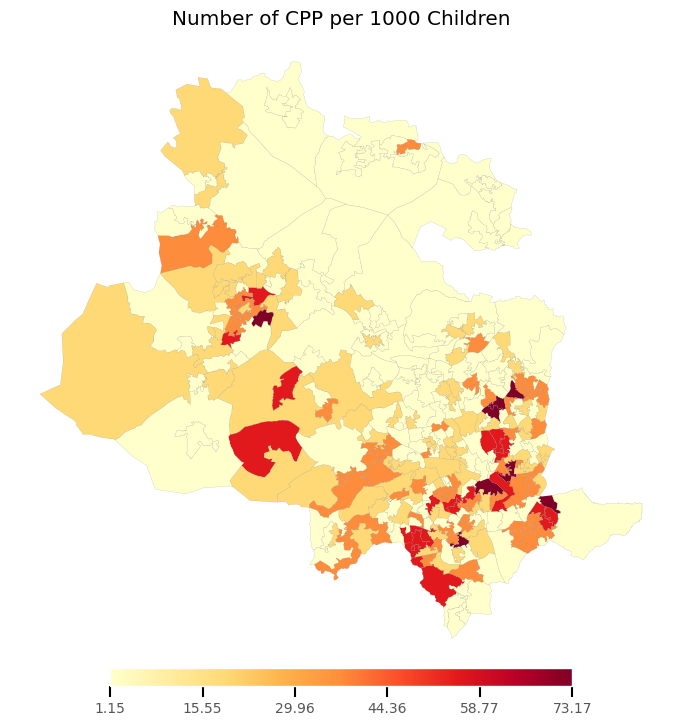

In [8]:
# Calculate intervention rates
cpp_rates = lah.calculate_intervention_rates(
    cpp,
    bradford_boundary_data,
    imd_data,
    population_data,
    intervention_name='CPP'
)

# Plot the intervention rate map
lah.plot_intervention_map(
    cpp_rates,
    intervention_name='CPP'
)

In [9]:
intervention_rate = cpp_rates[['lsoa21cd', 'children_count', 'TotalPop','intervention_children_per_1000_children']]
intervention_rate = intervention_rate.rename(columns={
    'TotalPop': 'children_population',
    'intervention_children_per_1000_children': 'cpp_children_per_1000_children'
})
intervention_rate_df = intervention_rate.sort_values(by='cpp_children_per_1000_children', ascending=False)
intervention_rate_df

,lsoa21cd,children_count,children_population,cpp_children_per_1000_children
87,E01010655,36,492,73.170732
177,E01010748,26,441,58.956916
40,E01010608,31,560,55.357143
44,E01010612,29,527,55.028463
159,E01010730,14,273,51.282051
...,...,...,...,...
61,E01010629,1,697,1.434720
58,E01010626,1,748,1.336898
309,E01033899,1,781,1.280410
303,E01033693,1,827,1.209190


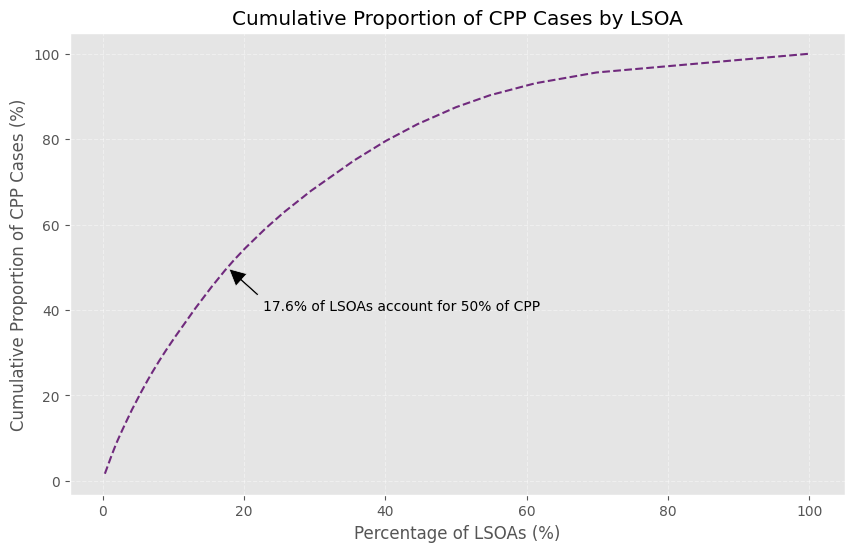

In [10]:
# Cumulative proportion plot
lah.plot_cumulative_distribution(
    cpp_rates,
    intervention_name='CPP'
)

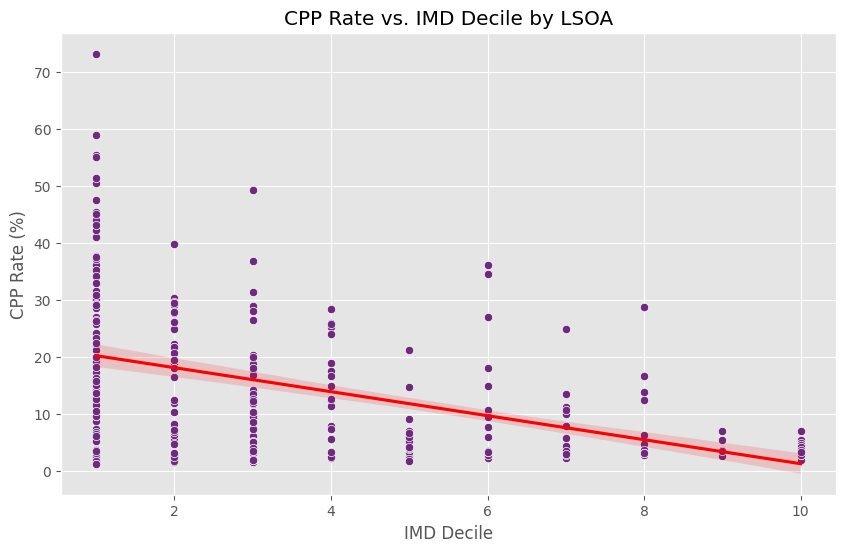


Statistical Analysis Results for CPP:
Pearson Correlation: -0.462 (p-value: 9.989e-18)

Linear Regression Results:
Slope: -2.107161
Intercept: 22.276
R-squared: 0.214
P-value: 9.989e-18


In [11]:
# Intervention rate vs IMD decile relationship
lah.analyze_imd_relationship(
    cpp_rates,
    intervention_name='CPP'
)

90th percentile cutoff value: 3.1276
Number of LSOAs above 90th percentile: 32
Number of children in high group (90th): 683
Number of children in other group (90th): 1458


80th percentile cutoff value: 2.5745
Number of LSOAs above 80th percentile: 63
Number of children in high group (80th): 1091
Number of children in other group (80th): 1050




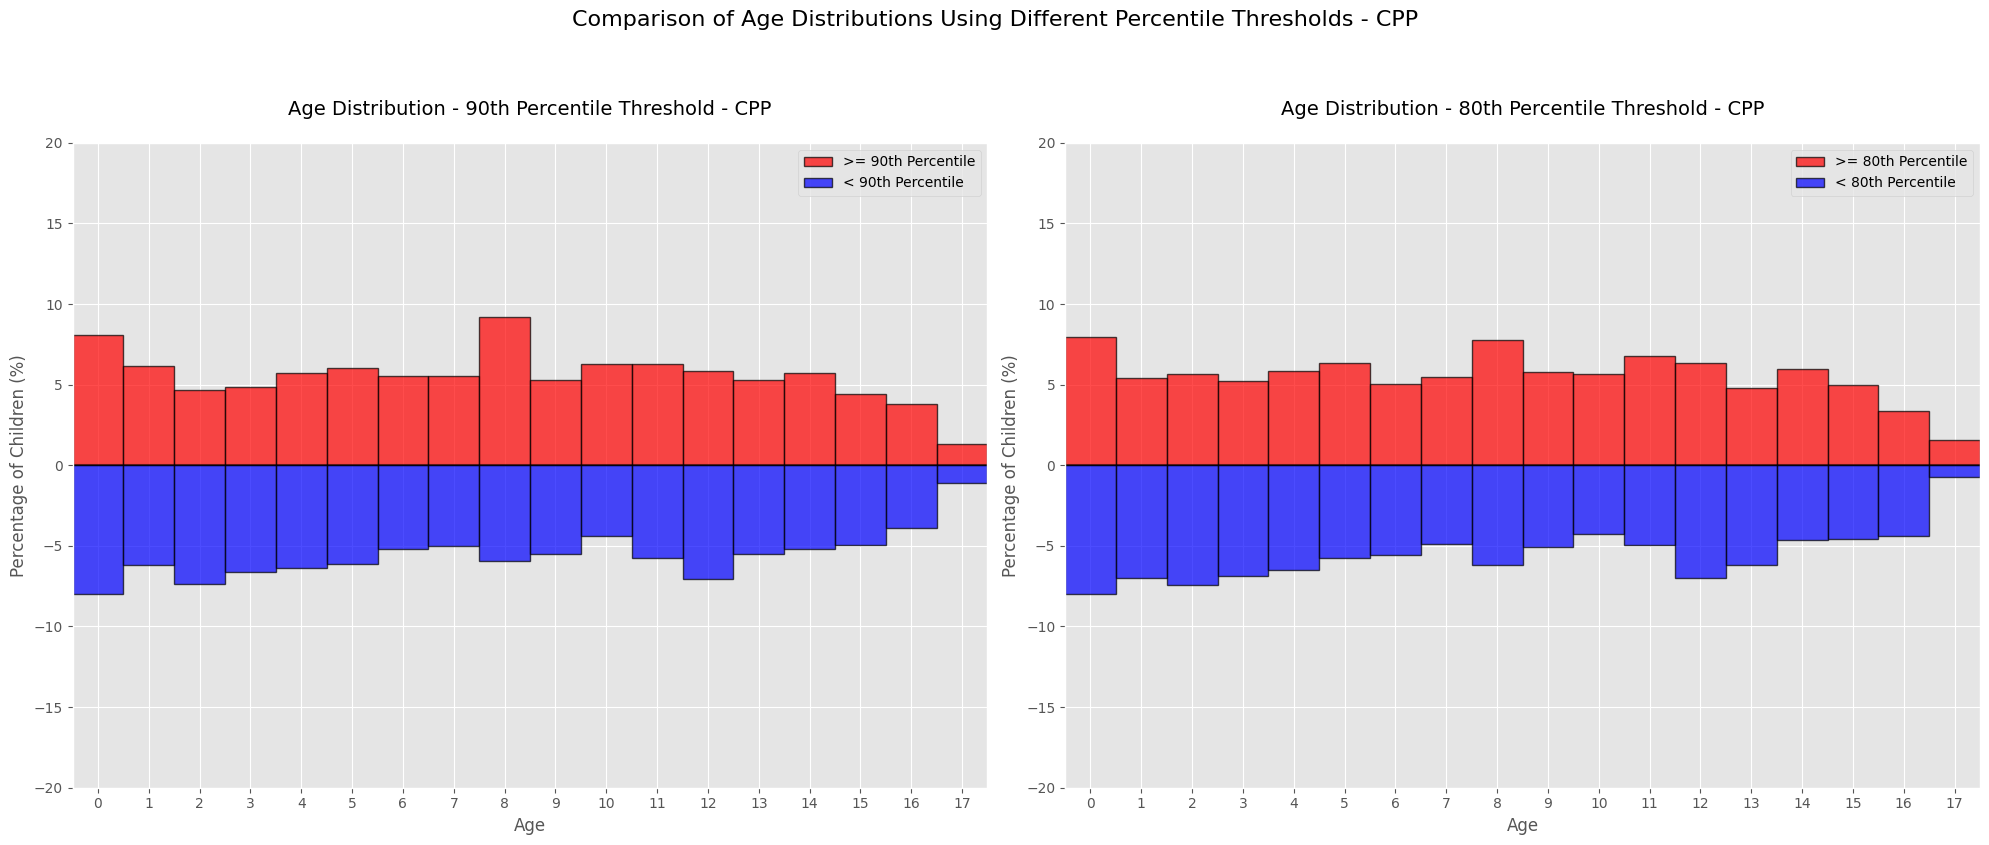

In [12]:
# Analyze age distribution
lah.analyze_age_distribution(
    merged_data,
    children_population,
    intervention_name='CPP',
    percentile_thresholds=[90, 80],
    age_column='age_at_entry'
)

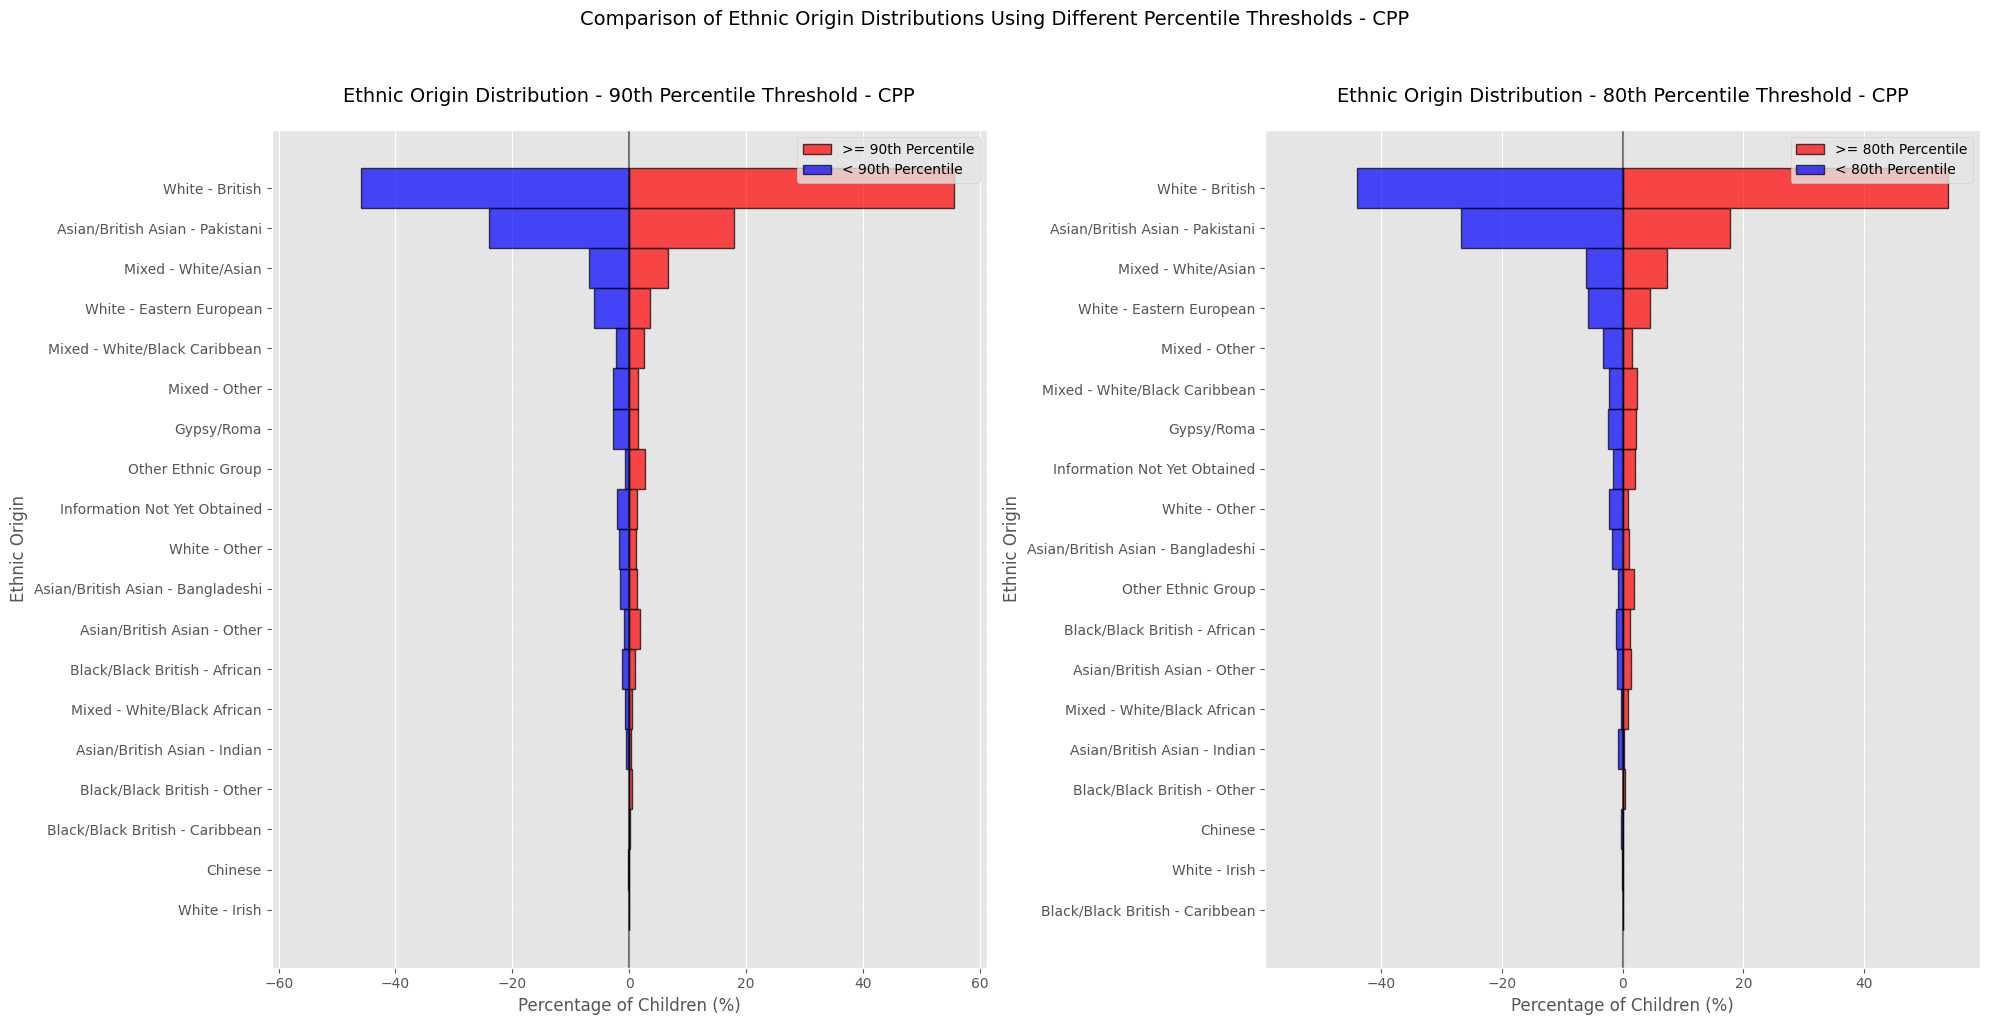

In [13]:
# Analyze ethnicity distribution
lah.analyze_ethnicity_distribution(
    merged_data,
    children_population,
    intervention_name='CPP',
    percentile_thresholds=[90, 80],
    ethnicity_column='EthnicOrigin'
)

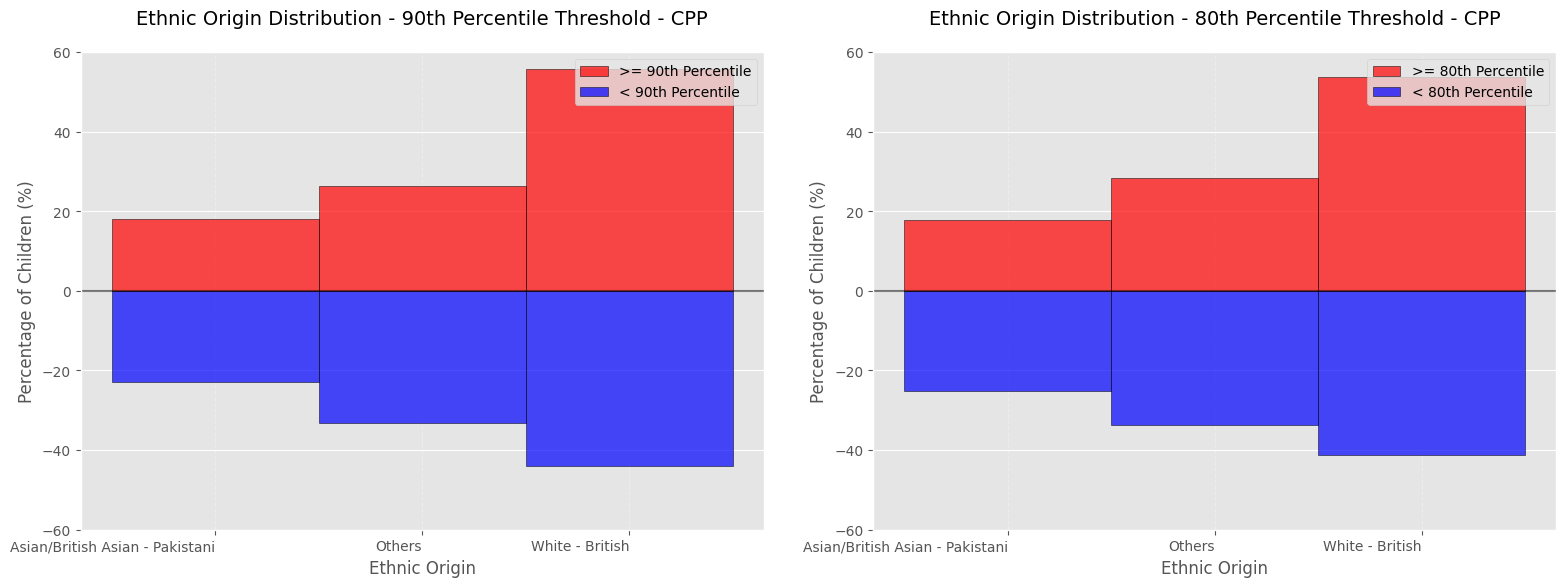

In [14]:
lah.analyze_grouped_ethnicity_distribution(
    merged_data,
    children_population,
    intervention_name='CPP',
    percentile_thresholds=[90, 80],
    ethnicity_column='EthnicOrigin'
)

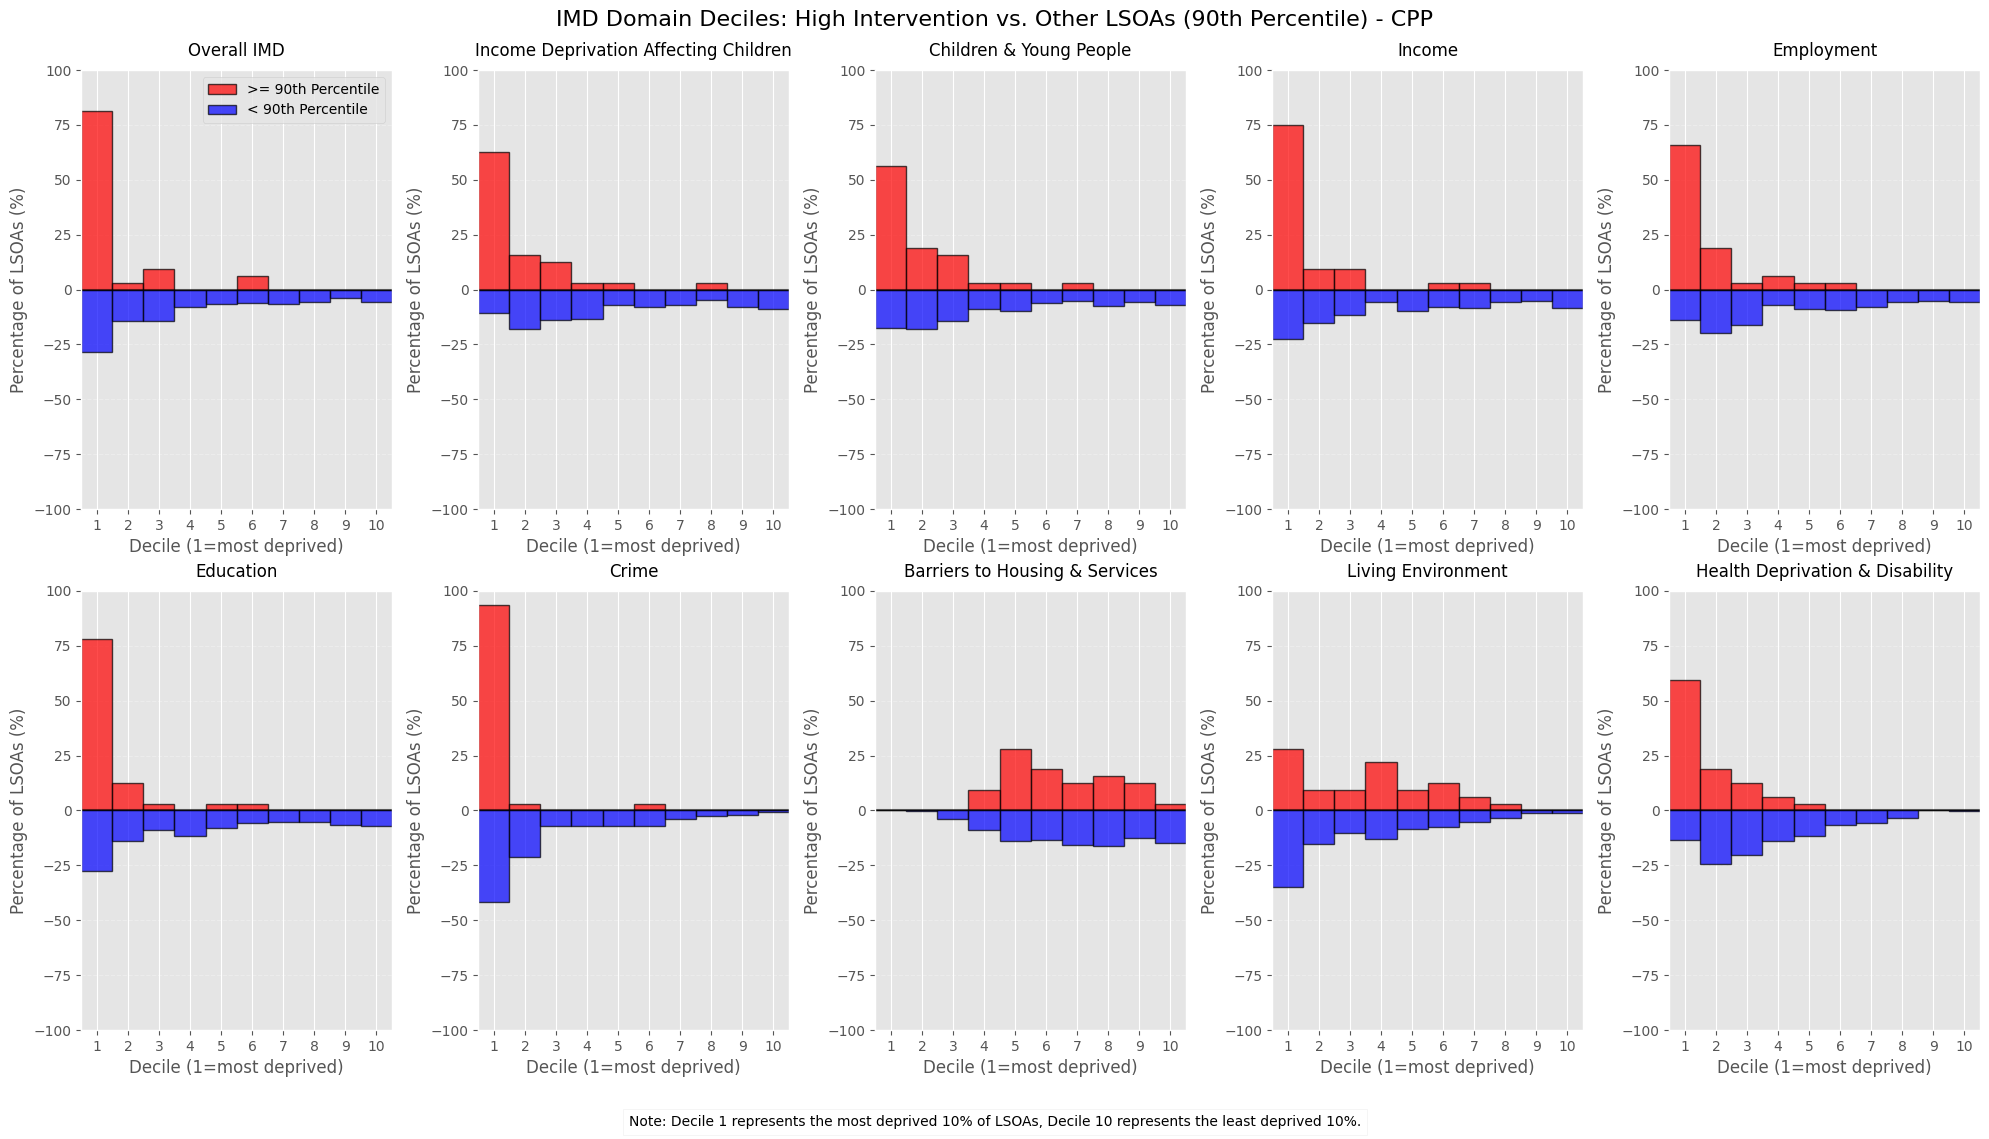

In [15]:
# Analyze IMD domains at 90th percentile
lah.analyze_imd_domains(
    children_population,
    percentile_threshold=90,
    intervention_name='CPP'
)

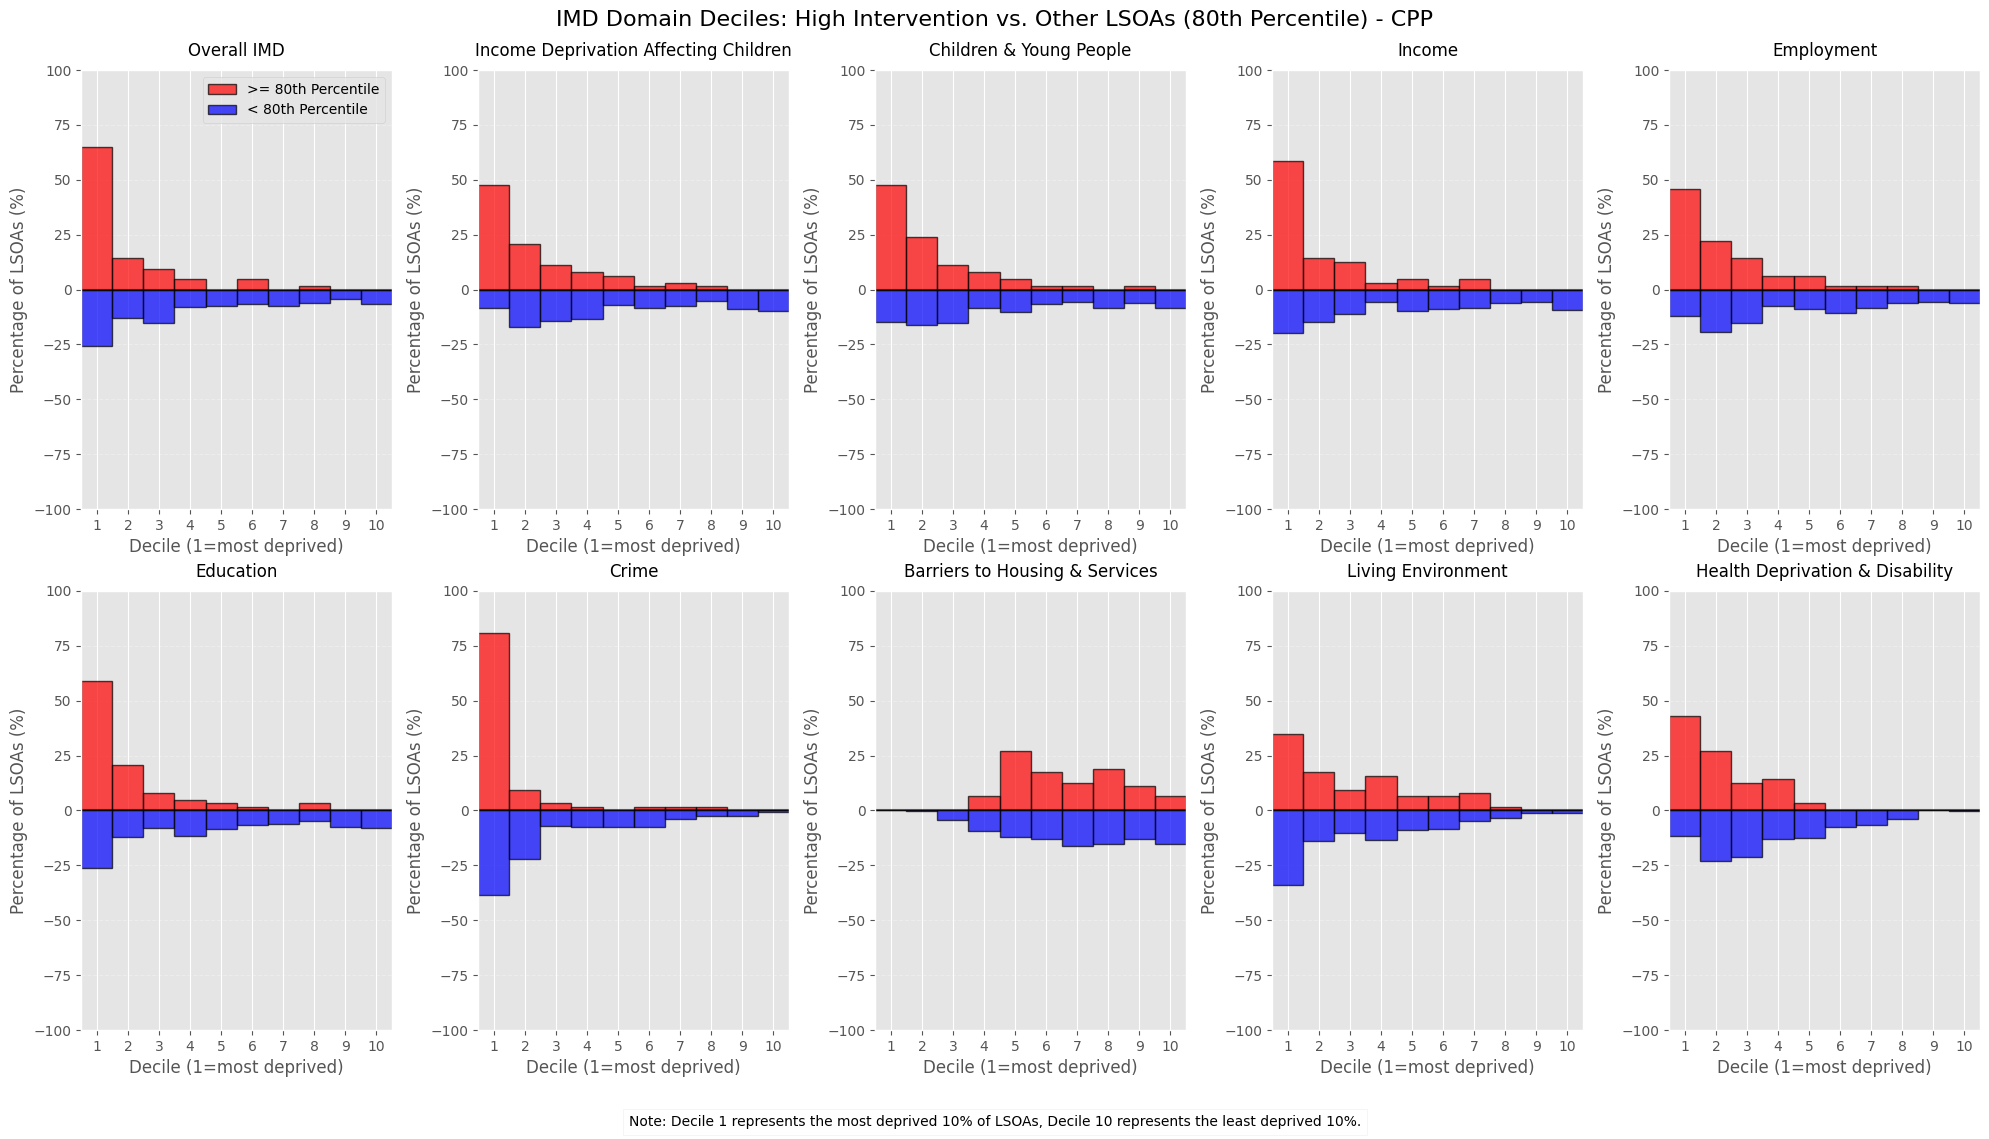

In [16]:
# Analyze IMD domains at 80th percentile
lah.analyze_imd_domains(
    children_population,
    percentile_threshold=80,
    intervention_name='CPP'
)